<a href="https://colab.research.google.com/github/sidhant-guliani/satellite-images-CNN/blob/master/multimultilabel_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from subprocess import check_output
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
import seaborn as sns

import os
import zipfile
import pandas as pd
import random

#the glob module is used to retrieve files/pathnames matching a specified pattern
from glob import glob

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.metrics import fbeta_score, precision_score, make_scorer, average_precision_score
from scipy.spatial.distance import pdist, squareform

import cv2
import warnings


from google.colab import drive
drive.mount('/content/drive')
#print(check_output(["ls", "../input"]).decode("utf8"))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive/Colab_Notebooks"

 503255_938046_compressed_planet.zip   Hello_tensorflow_example.ipynb
 cats_and_dogs_filtered		       keras-RNN_LanguageModel.ipynb
 dog_cat_cnn.ipynb		      'multimultilabel classification.ipynb'


In [3]:
local_zip = '/content/drive/My Drive/Colab_Notebooks/503255_938046_compressed_planet.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/amazon_data')
zip_ref.close()

In [4]:
!ls "/amazon_data/planet"
# https://www.kaggle.com/philschmidt/multilabel-classification-rainforest-eda

sample_submission.csv  test-jpg  train_classes.csv  train-jpg


In [5]:
base_dir = '/amazon_data/planet'
train_v2_file= os.path.join(base_dir, 'train_classes.csv')
submission_path = os.path.join(base_dir, 'sample_submission.csv')

In [6]:
df_train = pd.read_csv(train_v2_file)
df_test = pd.read_csv(submission_path)

In [7]:
df_test.head(5)

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [8]:
df_train.head(5)

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [9]:
unique_tags_train = df_train.tags.unique()
unique_tags_test = df_test.tags.unique()

print(len(unique_tags_train))
print(len(unique_tags_test))

449
1


In [10]:
print(df_train.shape)
print(df_test.shape)

(40479, 2)
(61191, 2)


In [11]:
all_tags = [item for sublist in list(df_train['tags'].apply(lambda row: row.split(" ")).values) for item in sublist]
print('total of {} non-unique tags in all training images'.format(len(all_tags)))
print('average number of labels per image {}'.format(1.0*len(all_tags)/df_train.shape[0]))

total of 116278 non-unique tags in all training images
average number of labels per image 2.8725511993873365


In [42]:
#print(all_tags)
print(len(all_tags))

116278


In [13]:
tags_counted_and_sorted = pd.DataFrame({'tag': all_tags}).groupby('tag').size().reset_index().sort_values(0, ascending=False)
tags_counted_and_sorted.head(18)

,tag,0
12,primary,37513
5,clear,28431
0,agriculture,12315
13,road,8071
16,water,7411
11,partly_cloudy,7261
8,cultivation,4547
9,habitation,3660
10,haze,2697
6,cloudy,2089


There are only a few tags, that occur very often in the data:

    primary
    clear
    agriculture
    road
    and water

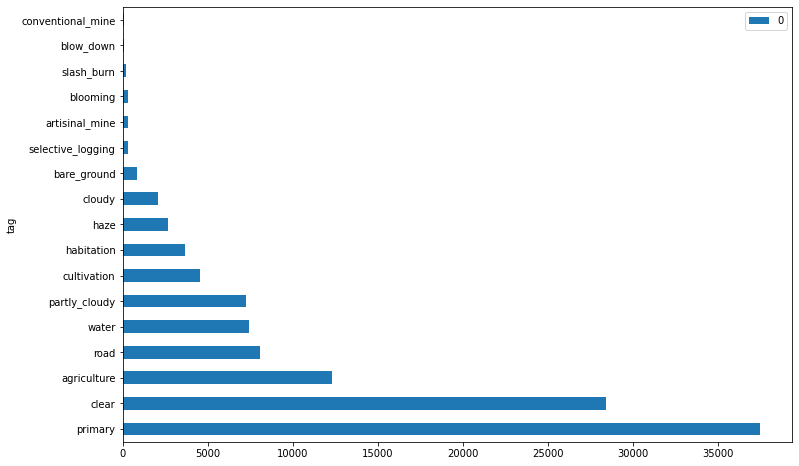

In [14]:
tags_counted_and_sorted.plot.barh(x='tag', y=0, figsize=(12,8))


# generate a fun bernoulli trial sample submission
Let's do something fun. We'll take the training tag distribution and sample from it as a prior for our test data. For that we will configure a bernoulli distribution for each sample with the observed training frequency and sample from that for each test image. With that we'll generate a submission without ever looking at the images. :)

In [15]:
tag_probas = tags_counted_and_sorted[0].values/tags_counted_and_sorted[0].values.sum()
indicators = np.hstack([bernoulli.rvs(p, 0, df_test.shape[0]).reshape(df_test.shape[0], 1) for p in tag_probas])
indicators = np.array(indicators)
indicators.shape

(61191, 17)

In [16]:
sorted_tags = tags_counted_and_sorted['tag'].values
all_test_tags = []
for index in range(indicators.shape[0]):
    all_test_tags.append(' '.join(list(sorted_tags[np.where(indicators[index, :] == 1)[0]])))
len(all_test_tags)


61191

In [17]:
df_test['tags'] = all_test_tags
df_test.to_csv('bernoulli_submission.csv', index=False)
df_test = df_test[~df_test.image_name.str.contains("file")]

In [18]:
df_test.head()


,image_name,tags
0,test_0,
1,test_1,
2,test_2,primary road
3,test_3,
4,test_4,


# Now lets look at the images and see what hapeening there

In [19]:
image_paths = sorted(glob('../amazon_data/planet/train-jpg/*.jpg'))[0:1000]
image_names = list(map(lambda row: row.split("/")[-1][:-4], image_paths))
image_names[0:10]

['train_0',
 'train_1',
 'train_10',
 'train_100',
 'train_1000',
 'train_10000',
 'train_10001',
 'train_10002',
 'train_10003',
 'train_10004']

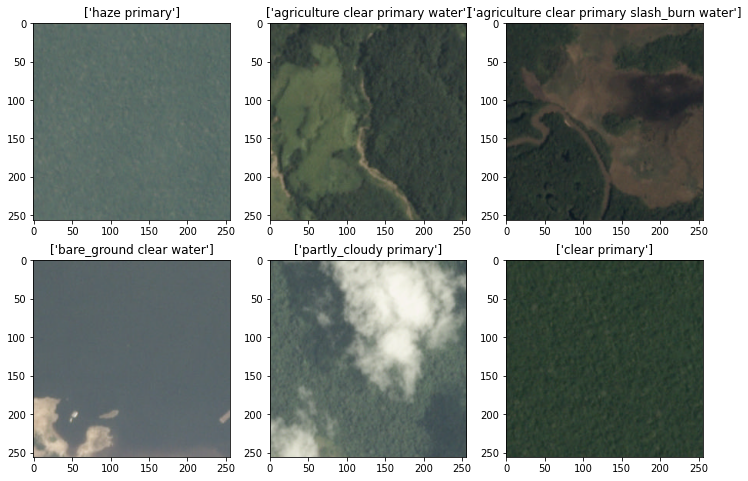

In [20]:
plt.figure(figsize=(12,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(plt.imread(image_paths[i]))
    plt.title(str(df_train[df_train.image_name == image_names[i]].tags.values))

The image ooks same size, which will make easy for us to process!
We are going to reduce the size of images because we want to work on small images for better run time.

In [21]:
n_samples = 25000
rescaled_dim = 20
dim = (rescaled_dim, rescaled_dim)

df_train['split_tags'] = df_train['tags'].map(lambda row: row.split(" "))
lb = MultiLabelBinarizer()
y = lb.fit_transform(df_train['split_tags'])
y = y[:n_samples]
X = np.squeeze(np.array([cv2.resize(plt.imread('../amazon_data/planet/train-jpg/{}.jpg'.format(name)), 
                                    dim, interpolation = cv2.INTER_LINEAR).reshape(1, -1) 
                                    for name in df_train.head(n_samples)['image_name'].values]))
X = MinMaxScaler().fit_transform(X)

In [22]:
df_train.head()

,image_name,tags,split_tags
0,train_0,haze primary,"[haze, primary]"
1,train_1,agriculture clear primary water,"[agriculture, clear, primary, water]"
2,train_2,clear primary,"[clear, primary]"
3,train_3,clear primary,"[clear, primary]"
4,train_4,agriculture clear habitation primary road,"[agriculture, clear, habitation, primary, road]"


In [23]:
print(X.shape, y.shape, lb.classes_)

(25000, 1600) (25000, 17) ['agriculture' 'artisinal_mine' 'bare_ground' 'blooming' 'blow_down'
 'clear' 'cloudy' 'conventional_mine' 'cultivation' 'habitation' 'haze'
 'partly_cloudy' 'primary' 'road' 'selective_logging' 'slash_burn' 'water']


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf = OneVsRestClassifier(LogisticRegression(C=10, penalty='l2'))

#clf.fit(X_train, y_train)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    clf.fit(X_train, y_train)

The F-beta score is the weighted harmonic mean of precision and recall, reaching its optimal value at 1 and its worst value at 0.

F-score measures the accuracy of a test using precision and recall. Precision is the ratio of true positives (tp) to all predicted positives (tp + fp). Recall is the ratio of true positives to all actual positives (tp + fn)
B is positive real. F2 score is when the beta = 2(it weighs recall higher than precision)

In [25]:

score = fbeta_score(y_test, clf.predict(X_test), beta=2, average=None)
print('score', score)
avg_sample_score = fbeta_score(y_test, clf.predict(X_test), beta=2, average='samples')
print('\n Average F2 test score {} \n'.format(avg_sample_score))
print('\n F2 test scores per tag:')
[(lb.classes_[l], score[l]) for l in score.argsort()[::-1]]

score [0.31300633 0.18617021 0.01162791 0.         0.         0.89282756
 0.52372426 0.08333333 0.00449843 0.07936508 0.01544402 0.04352557
 0.97522494 0.20327942 0.         0.         0.05953992]

 Average F2 test score 0.6790419201005236 


 F2 test scores per tag:


[('primary', 0.9752249371028954),
 ('clear', 0.8928275633592845),
 ('cloudy', 0.5237242614145031),
 ('agriculture', 0.31300633377522463),
 ('road', 0.2032794249775382),
 ('artisinal_mine', 0.18617021276595747),
 ('conventional_mine', 0.08333333333333333),
 ('habitation', 0.07936507936507937),
 ('water', 0.05953991880920163),
 ('partly_cloudy', 0.04352557127312296),
 ('haze', 0.015444015444015444),
 ('bare_ground', 0.011627906976744186),
 ('cultivation', 0.00449842555105713),
 ('slash_burn', 0.0),
 ('blow_down', 0.0),
 ('blooming', 0.0),
 ('selective_logging', 0.0)]

In [26]:
X_sub = np.squeeze(np.array([cv2.resize(plt.imread('../amazon_data/planet/test-jpg/{}.jpg'.format(name)), 
                                        (rescaled_dim, rescaled_dim), cv2.INTER_LINEAR).reshape(1, -1) 
                                        for name in df_test['image_name'].values if 'file' not in name]))
X_sub = MinMaxScaler().fit_transform(X_sub)
X_sub.shape

(40669, 1600)

In [35]:
y_sub = clf.predict(X_sub)
all_test_tags = []
for index in range(y_sub.shape[0]):
    all_test_tags.append(' '.join(list(lb.classes_[np.where(y_sub[index, :] == 1)[0]])))
all_test_tags[0:20]

['clear primary',
 'clear primary',
 'clear primary',
 'clear primary',
 'primary',
 'clear primary',
 'clear primary',
 'agriculture cloudy road',
 'clear primary',
 'primary',
 'clear primary',
 'clear primary',
 'cloudy',
 'clear primary',
 'clear primary',
 'clear primary',
 'agriculture clear primary',
 'clear primary',
 'clear primary',
 'clear primary']

In [28]:
len(all_test_tags)

40669

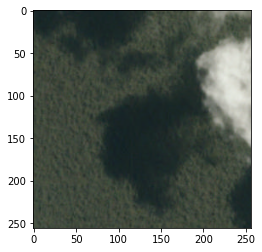

In [36]:
test_imgs = [plt.imread('../amazon_data/planet/test-jpg/{}.jpg'.format(name)) for name in df_test.head(20)['image_name'].values]
plt.imshow(test_imgs[10])


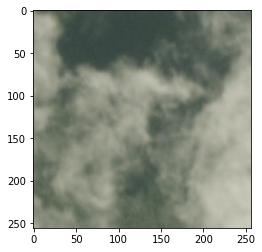

In [37]:
plt.imshow(test_imgs[4])


In [38]:
df_test['tags'] = all_test_tags
df_test.head()

,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,clear primary
3,test_3,clear primary
4,test_4,primary


In [39]:
df_test.to_csv('ovr_f2_{}.csv'.format(avg_sample_score), index=False)


##Image clustering
Without having to look at all of the images, a common technique is to cluster images by their native representation (pixel intensities) or some encoded version of it, e.g. by computing activations of a vision-based neural network.

For our purpose we will just use the pixel intensities and compute pairwise distances.

In [40]:
n_imgs = 600

all_imgs = []

for i in range(n_imgs):
    img = plt.imread(image_paths[i])
    img = cv2.resize(img, (100, 100), cv2.INTER_LINEAR).astype('float')
    img = cv2.normalize(img, None, 0.0, 1.0, cv2.NORM_MINMAX)
    img = img.reshape(1, -1)
    all_imgs.append(img)

img_mat = np.vstack(all_imgs)
img_mat.shape

(600, 40000)

array([0.08474576, 0.17514124, 0.1299435 , ..., 0.16384181, 0.14124294,
       1.        ])

(600, 600)


/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:620: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


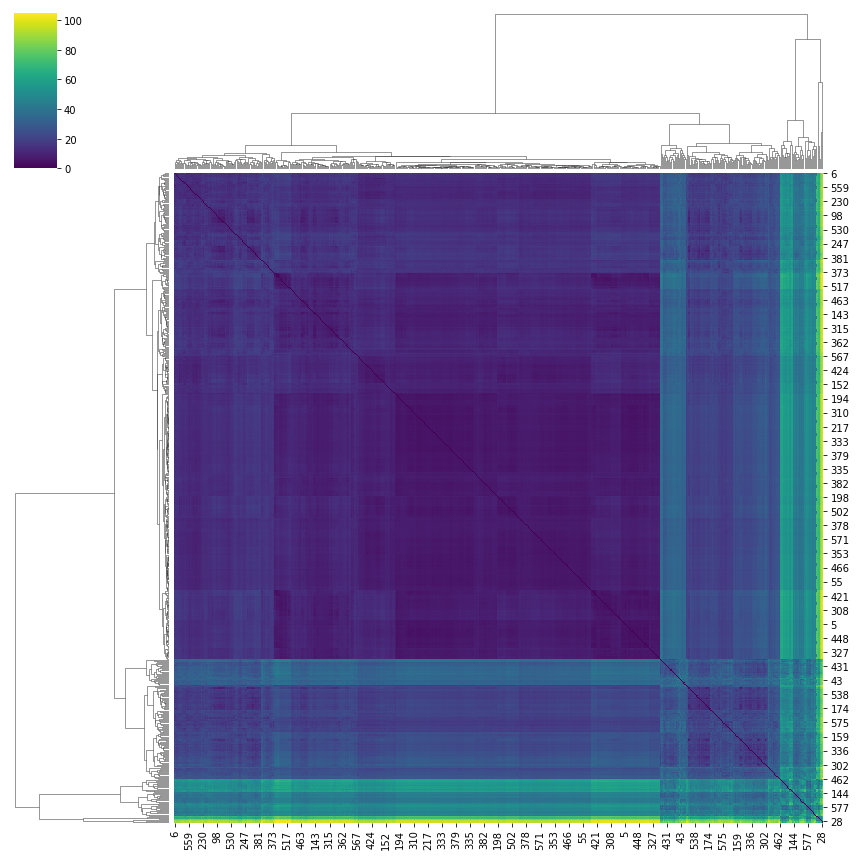

In [34]:
sq_dists = squareform(pdist(img_mat))
print(sq_dists.shape)

sns.clustermap(
    sq_dists,
    figsize=(12,12),
    cmap=plt.get_cmap('viridis')
)